In [16]:
import gym
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

## Q学習

In [2]:
class Q_Learning:
    @staticmethod
    def get_status(observation):
        """車の位置と速度を離散値に変換する
        Args:
                observation (np.array): [車の位置, 車の速度]
        Returns:
                int, int: 40等分に変換された車の位置と車の速度
        """
        env_low = env.observation_space.low # 位置と速度の最小値
        env_high = env.observation_space.high #　位置と速度の最大値
        env_dx = (env_high - env_low) / 40 # 40等分
        position = int((observation[0] - env_low[0])/env_dx[0])
        velocity = int((observation[1] - env_low[1])/env_dx[1])
        return position, velocity

    @staticmethod
    def update_q_table(q_table, action, observation, next_observation, reward):
        """Qテーブルを更新する
        Args:
                q_table (np.array): shape→(40,40,3)
                action (int): 0 or 1 or 2
                observation (np.array): 観測データ
                next_observation(np.array): 次の観測データ
                reward (float): 報酬
        Returns:
                np.array: 更新後のQテーブル
        """
        # 学習率
        alpha = 0.2
        # 時間割引き率
        gamma = 0.99

        # 行動後の状態で得られる最大行動価値 Q(s',a')
        next_position, next_velocity = Q_Learning.get_status(next_observation)
        next_max_q_value = max(q_table[next_position][next_velocity])

        # 行動前の状態の行動価値 Q(s,a)
        position, velocity = Q_Learning.get_status(observation)
        q_value = q_table[position][velocity][action]

        # 行動価値関数の更新
        q_table[position][velocity][action] = q_value + alpha * (reward + gamma * next_max_q_value - q_value)

        return q_table

    @staticmethod
    def get_action(q_table, observation):
        """ε-グリーディ法
        Args:
            q_table (np.array): shape→(40,40,3)
            observation (np.array): 観測データ
        Returns:
                int: 行動
        """
        epsilon = 0.002
        if np.random.uniform(0, 1) > epsilon:
            position, velocity = get_status(observation)
            action = np.argmax(q_table[position][velocity])
        else:
            action = np.random.choice([0, 1, 2])
        return action

## Q学習でのmain文

In [ ]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env.reset()
# Qテーブルの定義
q_table = np.zeros((40, 40, 3))
rewards = []

# 10000エピソードで学習する
for episode in range(10000):
    total_reward = 0
    observation = env.reset()[0]
    for _ in range(200):
        # ε-グリーディ法にて行動を決定
        action = Q_Learning.get_action(q_table, observation)
        # 車を動かして観測結果・報酬・ゲーム終了フラグ・詳細情報を取得
        data = env.step(action)
        next_observation = data[0]
        reward = data[1]
        done = data[2]
        info = data[3]
        # Qテーブルの更新
        q_table = Q_Learning.update_q_table(q_table, action, observation,
                                next_observation, reward)
        total_reward += reward

        observation = next_observation

        if done:
            # doneがTrueの場合は1エピソード終了
            if episode%100 == 0:
                print(f'episode: {episode}, total_reward: {total_reward}')
            rewards.append(total_reward)
            break

## Q学習で学習後の動作を確認

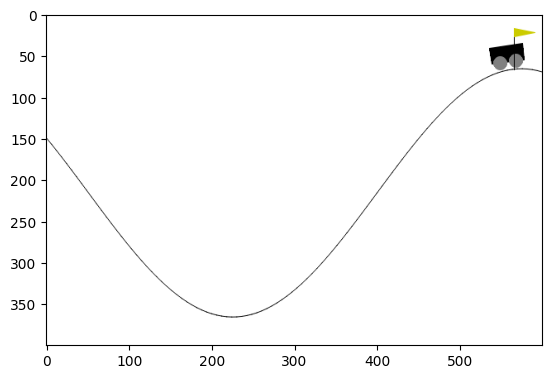

step: 187
finish


In [7]:
env.reset()
observation = env.reset()[0]
for step in range(200):
    plt.imshow(env.render())
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.close()
    action = Q_Learning.get_action(q_table, observation)
    data = env.step(action)
    next_observation = data[0]
    done = data[2]
    observation = next_observation
    print(f'step: {step}')
    
    if done:
        print('finish')
        break

## DQN

In [29]:
env = gym.make('MountainCar-v0')
nb_actions = env.action_space.n

model = Sequential([
    Flatten(input_shape=(1,)+ env.observation_space.shape),
    Dense(16),
    Activation('relu'),
    Dense(16),
    Activation('relu'),
    Dense(16),
    Activation('relu'),
    Dense(nb_actions),
    Activation('linear')
])

memory = SequentialMemory(limit=50000, window_length=1)

policy = EpsGreedyQPolicy(eps=0.001)
dqn = DQNAgent(model=model, nb_actions=nb_actions, gamma=0.99,
              memory=memory, nb_steps_warmup=10,
              target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

history = dqn.fit(env, nb_steps=50000, visualize=False,
                  verbose=2)

2023-02-23 06:55:19.894317: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_91_1/kernel/Assign' id:9081 op device:{requested: '', assigned: ''} def:{{{node dense_91_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_91_1/kernel, dense_91_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training for 50000 steps ...


2023-02-23 06:55:20.458258: W tensorflow/c/c_api.cc:291] Operation '{name:'activation_91/activation_91/Identity' id:8993 op device:{requested: '', assigned: ''} def:{{{node activation_91/activation_91/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_91/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-23 06:55:20.633889: W tensorflow/c/c_api.cc:291] Operation '{name:'count_71/Assign' id:9280 op device:{requested: '', assigned: ''} def:{{{node count_71/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_71, count_71/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or 

ValueError: setting an array element with a sequence.

In [ ]:
dqn.test(env, nb_episodes=1, visualize=True)